In [1]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import RandomSearch

In [2]:
df=pd.read_csv("C:\\Users\\Student\\Downloads\\Real_Combine.csv")
df.head()

,T,TM,Tm,SLP,H,VV,V,VM,PM 2.5
0,7.4,9.8,4.8,1017.6,93.0,0.5,4.3,9.4,219.720833
1,7.8,12.7,4.4,1018.5,87.0,0.6,4.4,11.1,182.187500
2,6.7,13.4,2.4,1019.4,82.0,0.6,4.8,11.1,154.037500
3,8.6,15.5,3.3,1018.7,72.0,0.8,8.1,20.6,223.208333
4,12.4,20.9,4.4,1017.3,61.0,1.3,8.7,22.2,200.645833


In [3]:
#pip install keras-tuner


In [4]:
df=df.dropna()
df.isnull().sum()


T         0
TM        0
Tm        0
SLP       0
H         0
VV        0
V         0
VM        0
PM 2.5    0
dtype: int64

In [5]:
x=df.iloc[:,:-1]
y=df.iloc[:,-1]

In [6]:
def hyper_tune(param):
    model=keras.Sequential()
    for i in range(param.Int('num_layers',2,20)):
        model.add(layers.Dense(units=param.Int('units_'+str(i),
                                              min_value=32,
                                              max_value=512,
                                              step=32),
                              activation='tanh'))
        model.add(layers.Dense(1,activation='linear'))
        model.compile(
            optimizer=keras.optimizers.Adam(
                param.Choice('learning_rate',[1e-2,1e-3,1e-4])),
                loss='mean_absolute_error',
                metrics=['mean_absolute_error'])
    return model

In [7]:
tuner=RandomSearch(
    hyper_tune,
    objective='val_mean_absolute_error',
    max_trials=5,
    executions_per_trial=3,
    directory='project',
    overwrite=True,
    project_name='Air Quality Index'
)

In [8]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}


In [9]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=2)
tuner.search(x_train,y_train,epochs=5,validation_data=(x_test,y_test))

Trial 5 Complete [00h 00m 08s]
val_mean_absolute_error: 64.1045150756836

Best val_mean_absolute_error So Far: 64.1045150756836
Total elapsed time: 00h 00m 43s
INFO:tensorflow:Oracle triggered exit


#plotting

Epoch 1/5
24/24 [==============================] - 2s 9ms/step - loss: 80.9521 - mean_absolute_error: 80.9521 - val_loss: 64.7570 - val_mean_absolute_error: 64.7570
Epoch 2/5
24/24 [==============================] - 0s 2ms/step - loss: 67.0371 - mean_absolute_error: 67.0371 - val_loss: 64.1810 - val_mean_absolute_error: 64.1810
Epoch 3/5
24/24 [==============================] - 0s 3ms/step - loss: 66.9101 - mean_absolute_error: 66.9101 - val_loss: 64.1679 - val_mean_absolute_error: 64.1679
Epoch 4/5
24/24 [==============================] - 0s 2ms/step - loss: 66.8363 - mean_absolute_error: 66.8363 - val_loss: 64.2509 - val_mean_absolute_error: 64.2509
Epoch 5/5
24/24 [==============================] - 0s 3ms/step - loss: 66.8846 - mean_absolute_error: 66.8846 - val_loss: 64.0655 - val_mean_absolute_error: 64.0655


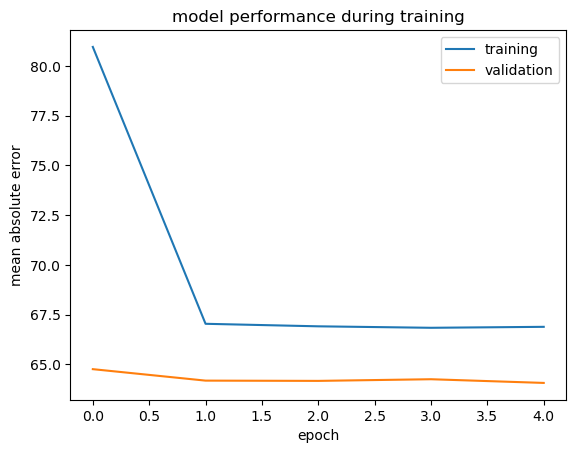

In [10]:
import matplotlib.pyplot as plt
best_hps=tuner.get_best_hyperparameters(1)[0]
model=hyper_tune(best_hps)
history=model.fit(x_train,y_train,epochs=5,validation_data=(x_test,y_test))

plt.plot(history.history['mean_absolute_error'],label='training')
plt.plot(history.history['val_mean_absolute_error'],label='validation')
plt.title('model performance during training')
plt.xlabel('epoch')
plt.ylabel('mean absolute error')
plt.legend()
plt.show()